In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
DATASET_PATH = r"C:\Users\Sarvagya\OneDrive\Desktop\New folder\Lang-id\Dataset"  # Change this to your dataset path

In [3]:
# # --- Feature Extraction ---
# def extract_page_features(img):
#     # Preprocessing
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (5, 5), 0)
#     _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
#     # 1. Contour Analysis 
#     contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contour_density = len(contours) / (img.shape[0] * img.shape[1]) * 1e4  # Scaled
    
#     # 2. Horizontal Projections 
#     horizontal_proj = np.sum(binary, axis=1)
#     horiz_line_strength = np.max(horizontal_proj) / binary.shape[1]
    
#     # 3. Edge Density
#     edges = cv2.Canny(binary, 50, 150)
#     edge_density = np.sum(edges) / edges.size
    
#     # 4. Vertical Density Variation 
#     vertical_strips = np.array_split(binary, 8, axis=1)  # Split into 8 vertical strips
#     strip_densities = [np.sum(strip) / strip.size for strip in vertical_strips]
#     vert_density_var = np.var(strip_densities)
    
#     # 5. Top/Bottom Density Ratio
#     top_half = binary[:binary.shape[0]//2, :]
#     bottom_half = binary[binary.shape[0]//2:, :]
#     density_ratio = np.sum(top_half) / (np.sum(bottom_half) + 1e-6)

#     # New Feature 1: Vertical Line Detection
#     vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
#     vertical_lines = cv2.erode(binary, vertical_kernel, iterations=1)
#     vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=1)
#     vertical_line_density = np.sum(vertical_lines) / vertical_lines.size

#     # New Feature 2: Headline (Shirorekha) Detection
#     horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
#     headline = cv2.erode(binary, horizontal_kernel, iterations=1)
#     headline = cv2.dilate(headline, horizontal_kernel, iterations=1)
#     headline_strength = np.sum(headline[:binary.shape[0]//3, :]) / (binary.shape[1] * binary.shape[0] // 3)

#     # New Feature 3: Aspect Ratio of Connected Components
#     labels = cv2.connectedComponents(binary)[1]
#     unique_labels = np.unique(labels)
#     aspect_ratios = []
#     for label in unique_labels[1:]:  # Skip background label
#         component = (labels == label).astype(np.uint8)
#         x, y, w, h = cv2.boundingRect(component)
#         aspect_ratio = w / h if h != 0 else 0
#         aspect_ratios.append(aspect_ratio)
#     mean_aspect_ratio = np.mean(aspect_ratios) if aspect_ratios else 0

#     # New Feature 4: Ascenders and Descenders
#     middle_strip = binary[binary.shape[0]//4:3*binary.shape[0]//4, :]
#     top_bottom_strip = np.vstack((binary[:binary.shape[0]//4, :], binary[3*binary.shape[0]//4:, :]))
#     ascender_descender_ratio = np.sum(top_bottom_strip) / (np.sum(middle_strip) + 1e-6)

#     # top_10_rows = binary[:10, :]  # Look at top 10 pixels
#     # headline_strength = np.mean(top_10_rows)  # Higher = Hindi
    
#     # # NEW FEATURE 2: Vertical Line Count (Hindi has more verticals)
#     # vertical_lines = cv2.erode(binary, np.ones((3,1), np.uint8), iterations=1)
#     # vertical_count = np.sum(vertical_lines) / vertical_lines.size  # Higher = Hindi
    
#     return np.array([
#         contour_density, 
#         horiz_line_strength, 
#         edge_density, 
#         vert_density_var,
#         density_ratio,
#         *strip_densities,  # Include all 8 strip densities
#         # headline_strength,   # New feature 1
#         # vertical_count       # New feature 2
#         vertical_line_density,
#         headline_strength,
#         mean_aspect_ratio,
#         ascender_descender_ratio
#     ])

def extract_page_features(img):
    # Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 1. Contour Analysis 
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_density = len(contours) / (img.shape[0] * img.shape[1]) * 1e4  # Scaled
    
    # 2. Horizontal Projections 
    horizontal_proj = np.sum(binary, axis=1)
    horiz_line_strength = np.max(horizontal_proj) / binary.shape[1]
    
    # 3. Edge Density
    edges = cv2.Canny(binary, 50, 150)
    edge_density = np.sum(edges) / edges.size
    
    # 4. Vertical Density Variation 
    vertical_strips = np.array_split(binary, 8, axis=1)  # Split into 8 vertical strips
    strip_densities = [np.sum(strip) / strip.size for strip in vertical_strips]
    vert_density_var = np.var(strip_densities)

    
    # 5. Top/Bottom Density Ratio
    top_half = binary[:binary.shape[0]//2, :]
    bottom_half = binary[binary.shape[0]//2:, :]
    density_ratio = np.sum(top_half) / (np.sum(bottom_half) + 1e-6)

    # 6. Vertical Line Detection (more prominent in Hindi)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    vertical_lines = cv2.erode(binary, vertical_kernel, iterations=1)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=1)
    vertical_line_density = np.sum(vertical_lines) / vertical_lines.size

    # 7. Headline (Shirorekha) Detection (characteristic of Hindi)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    headline = cv2.erode(binary, horizontal_kernel, iterations=1)
    headline = cv2.dilate(headline, horizontal_kernel, iterations=1)
    headline_strength = np.sum(headline[:binary.shape[0]//3, :]) / (binary.shape[1] * binary.shape[0] // 3)

    # 8. Aspect Ratio of Connected Components
    labels = cv2.connectedComponents(binary)[1]
    unique_labels = np.unique(labels)
    aspect_ratios = []
    for label in unique_labels[1:]:  # Skip background label
        component = (labels == label).astype(np.uint8)
        x, y, w, h = cv2.boundingRect(component)
        aspect_ratio = w / h if h != 0 else 0
        aspect_ratios.append(aspect_ratio)
    mean_aspect_ratio = np.mean(aspect_ratios) if aspect_ratios else 0

    # 9. Ascenders and Descenders (more prominent in English)
    middle_strip = binary[binary.shape[0]//4:3*binary.shape[0]//4, :]
    top_bottom_strip = np.vstack((binary[:binary.shape[0]//4, :], binary[3*binary.shape[0]//4:, :]))
    ascender_descender_ratio = np.sum(top_bottom_strip) / (np.sum(middle_strip) + 1e-6)

    # 10. Horizontal Line Continuity (English tends to have more continuous horizontal lines)
    horizontal_lines = cv2.erode(binary, np.ones((1, 15), np.uint8), iterations=1)
    horizontal_line_continuity = np.sum(horizontal_lines) / horizontal_lines.size

    # 11. Character Separation (English tends to have more separated characters)
    dilated = cv2.dilate(binary, np.ones((3, 3), np.uint8), iterations=1)
    character_separation = np.sum(dilated - binary) / binary.size

    features = np.array([
        contour_density, 
        horiz_line_strength, 
        # vertical_centroid,
        edge_density, 
        vert_density_var,
        density_ratio,
        vertical_line_density,
        headline_strength,
        mean_aspect_ratio,
        ascender_descender_ratio,
        horizontal_line_continuity,
        character_separation
    ])

    # Normalize features
    features = (features - np.mean(features)) / (np.std(features) + 1e-10)

    return features


In [4]:
# loading word level dataset:
def load_dataset(dataset_path, split):
    images = []
    labels = []
    
    split_path = os.path.join(dataset_path, split)
    
    for language in ["Hindi", "English"]:  # Two language classes
        language_path = os.path.join(split_path, language, "image")

        for img_filename in tqdm(os.listdir(language_path), desc=f"Loading {split} - {language}"):
            img_path = os.path.join(language_path, img_filename)
            image = cv2.imread(img_path)

            if image is not None:
                image = cv2.resize(image, (128, 128))  # Resize to fixed size
                
                # Extract features
                # hog_features = extract_hog_features(image)
                # lbp_features = extract_lbp_features(image)
                # stat_features = extract_statistical_features(image)
                # dev_features = extract_devanagari_features(image)

                # Combine all features
                # features = np.hstack([hog_features, lbp_features, stat_features, dev_features])
                features = extract_page_features(image)
                images.append(features)
                labels.append(1 if language == "Hindi" else 0)  # Hindi = 1, English = 0

    return np.array(images), np.array(labels)


In [5]:
# Load training and testing data
X_train, y_train = load_dataset(DATASET_PATH, "train")
X_test, y_test = load_dataset(DATASET_PATH, "test")

Loading test - English: 100%|██████████| 13601/13601 [01:40<00:00, 135.30it/s]


In [6]:
# -------------- STEP 4: Feature Selection (Optional) --------------
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
feature_scores = selector.scores_

# Optional: Print feature scores
print("\nFeature Scores:")
for i, score in enumerate(feature_scores):
    print(f"Feature {i+1}: {score:.2f}")


Feature Scores:
Feature 1: 15615.21
Feature 2: 25890.86
Feature 3: 18392.75
Feature 4: 9957.02
Feature 5: 3573.82
Feature 6: 13108.25
Feature 7: 1171.09
Feature 8: 3473.84
Feature 9: 5377.19
Feature 10: 73.37
Feature 11: 11251.45


In [7]:

from sklearn.ensemble import RandomForestClassifier
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    
clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=7,
        class_weight="balanced",  # Handle imbalanced data
        random_state=42
    )
    
    # Train
history= clf.fit(X_train, y_train)
    
    # Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.1f}%")


Train samples: 170605, Test samples: 34112

Accuracy: 87.6%


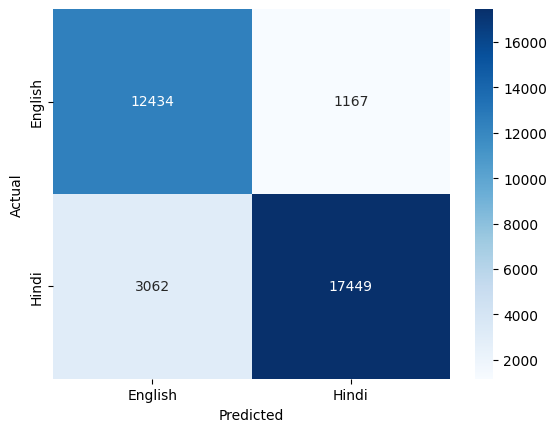

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['English', 'Hindi'], 
            yticklabels=['English', 'Hindi'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Predicted Language: English
Probability of English: 0.84
Probability of Hindi: 0.16


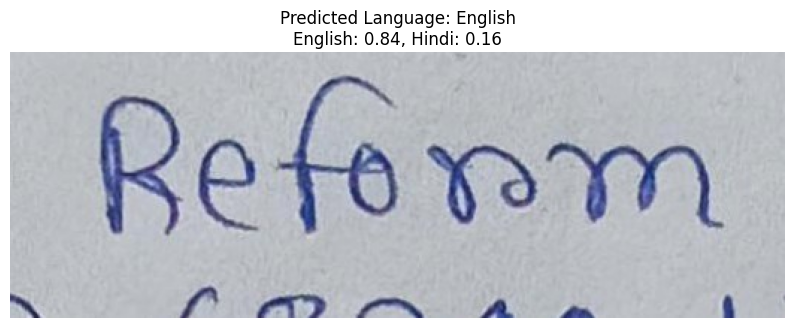

In [10]:
import matplotlib.pyplot as plt
def predict_language(image_path, model):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    img = cv2.resize(img, (128, 128))  # Resize to match training data
    
    # Extract features
    features = extract_page_features(img)
    
    # Reshape features to match model input
    features = features.reshape(1, -1)
    
    # Predict
    prediction = model.predict(features)
    
    # Get probability scores
    probabilities = model.predict_proba(features)[0]
    
    # Map prediction to language
    language = "Hindi" if prediction[0] == 1 else "English"
    
    
    return language, probabilities

# Test the function with a new image
new_image_path = r"C:\Users\Sarvagya\OneDrive\Desktop\New folder (2)\396706.jpg"
predicted_language, probabilities = predict_language(new_image_path, clf)

print(f"Predicted Language: {predicted_language}")
print(f"Probability of English: {probabilities[0]:.2f}")
print(f"Probability of Hindi: {probabilities[1]:.2f}")



# Visualize the result
img = cv2.imread(new_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title(f"Predicted Language: {predicted_language}\nEnglish: {probabilities[0]:.2f}, Hindi: {probabilities[1]:.2f}")
plt.axis('off')
plt.show()

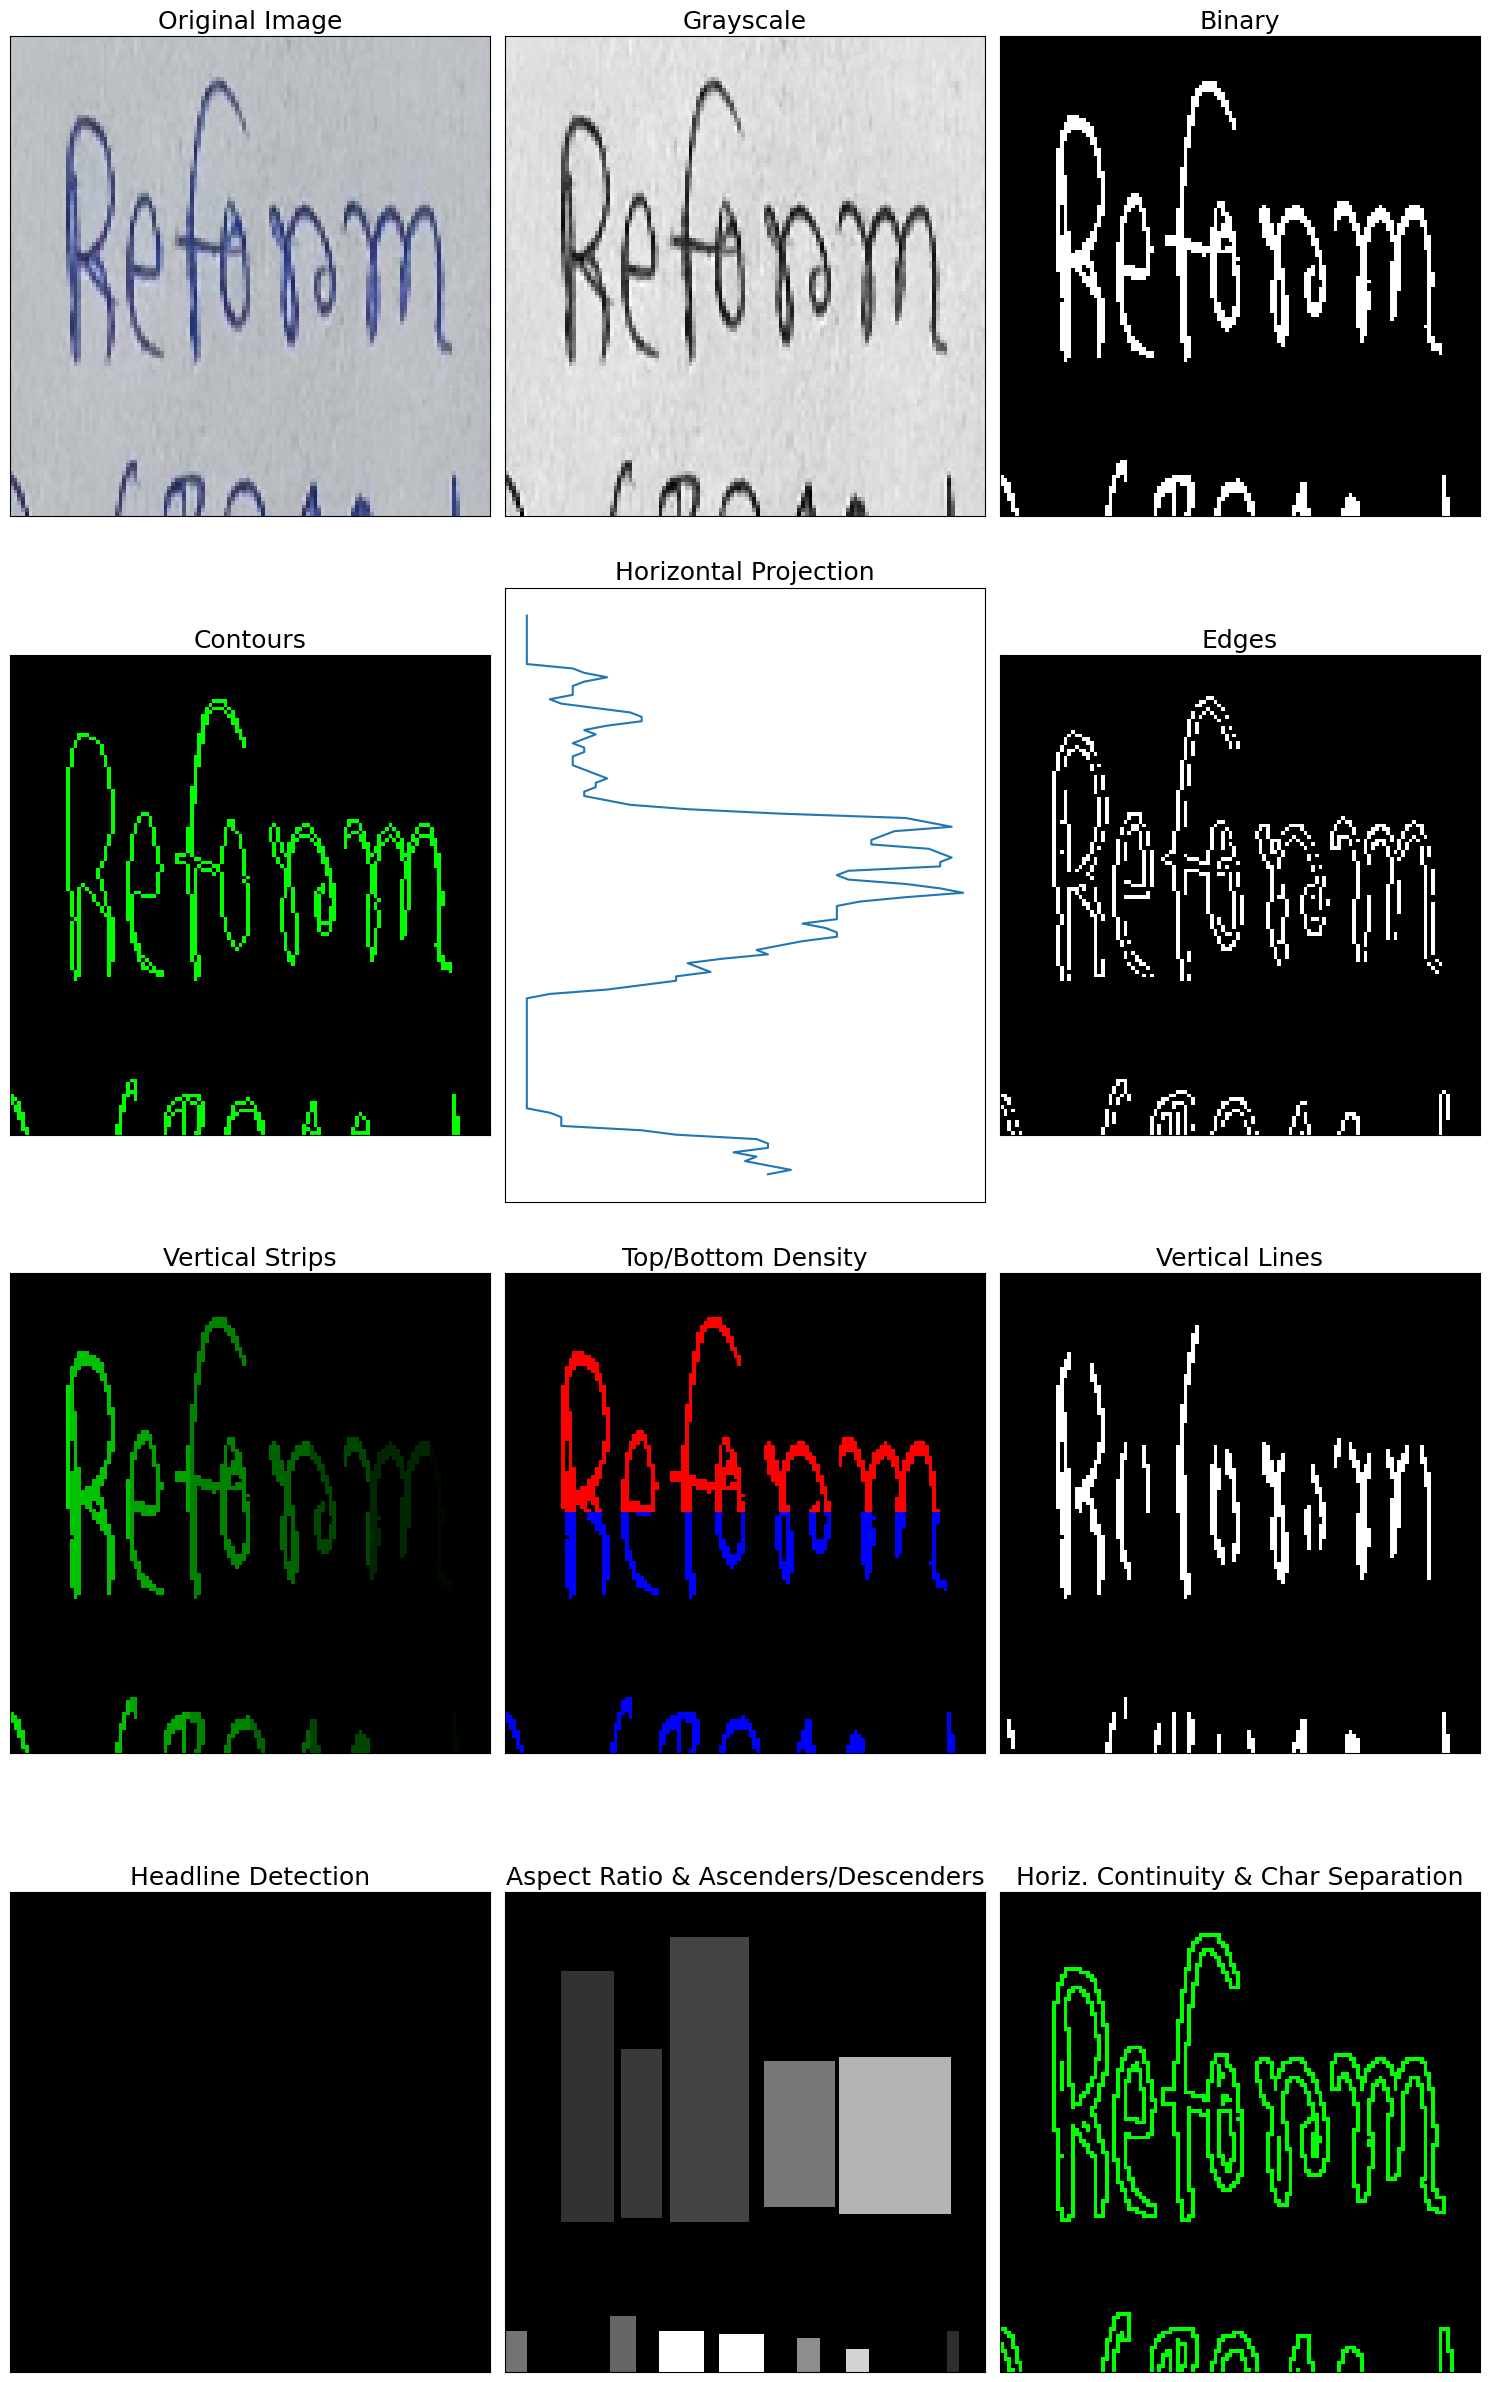


Extracted Features:
Contour Density: -0.4481
Horizontal Line Strength: 0.8907
Edge Density: -0.3160
Vertical Density Variation: 2.9022
Top/Bottom Density Ratio: -0.5210
Vertical Line Density: -0.1277
Headline Strength: -0.5355
Mean Aspect Ratio: -0.5283
Ascender/Descender Ratio: -0.5321
Horizontal Line Continuity: -0.5314
Character Separation: -0.2530


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_preprocessing_and_features(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize to match training data
    
    # Preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(4, 3, figsize=(15, 25))
    # fig.suptitle("Preprocessing and Feature Extraction Visualization", fontsize=15)
    
    # Original Image
    axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title("Original Image", fontsize=18)
    
    # Grayscale
    axs[0, 1].imshow(gray, cmap='gray')
    axs[0, 1].set_title("Grayscale", fontsize=18)
    
    # Binary
    axs[0, 2].imshow(binary, cmap='gray')
    axs[0, 2].set_title("Binary", fontsize=18)
    
    # 1. Contour Analysis
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(img)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 1)
    axs[1, 0].imshow(contour_img)
    axs[1, 0].set_title("Contours", fontsize=18)
    
    # 2. Horizontal Projections
    horizontal_proj = np.sum(binary, axis=1)
    axs[1, 1].plot(horizontal_proj, range(len(horizontal_proj)))
    axs[1, 1].set_title("Horizontal Projection", fontsize=18)
    axs[1, 1].invert_yaxis()
    
    # 3. Edge Density
    edges = cv2.Canny(binary, 50, 150)
    axs[1, 2].imshow(edges, cmap='gray')
    axs[1, 2].set_title("Edges", fontsize=18)
    
    # 4. Vertical Density Variation
    vertical_strips = np.array_split(binary, 8, axis=1)
    strip_img = np.zeros_like(img)
    for i, strip in enumerate(vertical_strips):
        strip_img[:, i*16:(i+1)*16] = strip[:, :, np.newaxis] * [0, 255//8 * (i+1), 0]
    axs[2, 0].imshow(strip_img)
    axs[2, 0].set_title("Vertical Strips", fontsize=18)
    
    # 5. Top/Bottom Density Ratio
    top_half = binary[:binary.shape[0]//2, :]
    bottom_half = binary[binary.shape[0]//2:, :]
    density_img = np.zeros_like(img)
    density_img[:binary.shape[0]//2, :, 0] = top_half
    density_img[binary.shape[0]//2:, :, 2] = bottom_half
    axs[2, 1].imshow(density_img)
    axs[2, 1].set_title("Top/Bottom Density", fontsize=18)
    
    # 6. Vertical Line Detection
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
    vertical_lines = cv2.erode(binary, vertical_kernel, iterations=1)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=1)
    axs[2, 2].imshow(vertical_lines, cmap='gray')
    axs[2, 2].set_title("Vertical Lines", fontsize=18)
    
    # 7. Headline (Shirorekha) Detection
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    headline = cv2.erode(binary, horizontal_kernel, iterations=1)
    headline = cv2.dilate(headline, horizontal_kernel, iterations=1)
    axs[3, 0].imshow(headline, cmap='gray')
    axs[3, 0].set_title("Headline Detection", fontsize=18)
    
    # 8 & 9. Aspect Ratio and Ascenders/Descenders
    labels = cv2.connectedComponents(binary)[1]
    unique_labels = np.unique(labels)
    aspect_ratio_img = np.zeros_like(img)
    for label in unique_labels[1:]:
        component = (labels == label).astype(np.uint8)
        x, y, w, h = cv2.boundingRect(component)
        aspect_ratio = w / h if h != 0 else 0
        color = int(255 * aspect_ratio)
        cv2.rectangle(aspect_ratio_img, (x, y), (x+w, y+h), (color, color, color), -1)
    axs[3, 1].imshow(aspect_ratio_img)
    axs[3, 1].set_title("Aspect Ratio & Ascenders/Descenders", fontsize=18)
    
    # 10 & 11. Horizontal Line Continuity and Character Separation
    horizontal_lines = cv2.erode(binary, np.ones((1, 15), np.uint8), iterations=1)
    dilated = cv2.dilate(binary, np.ones((3, 3), np.uint8), iterations=1)
    char_separation = dilated - binary
    combined = np.zeros_like(img)
    combined[:, :, 0] = horizontal_lines
    combined[:, :, 1] = char_separation
    axs[3, 2].imshow(combined)
    axs[3, 2].set_title("Horiz. Continuity & Char Separation" , fontsize=18)
    
    # Remove axis ticks
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Extract and print features
    features = extract_page_features(img)
    feature_names = [
        "Contour Density", "Horizontal Line Strength", "Edge Density", 
        "Vertical Density Variation", "Top/Bottom Density Ratio",
        "Vertical Line Density", "Headline Strength", "Mean Aspect Ratio",
        "Ascender/Descender Ratio", "Horizontal Line Continuity", "Character Separation"
    ]
    
    print("\nExtracted Features:")
    for name, value in zip(feature_names, features):
        print(f"{name}: {value:.4f}")

# Use the function with your test image
visualize_preprocessing_and_features(new_image_path)

In [107]:
import joblib
joblib.dump(clf, 'model.pkl')


['model.pkl']

In [128]:
from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85     13601
           1       0.94      0.85      0.89     20511

    accuracy                           0.88     34112
   macro avg       0.87      0.88      0.87     34112
weighted avg       0.88      0.88      0.88     34112



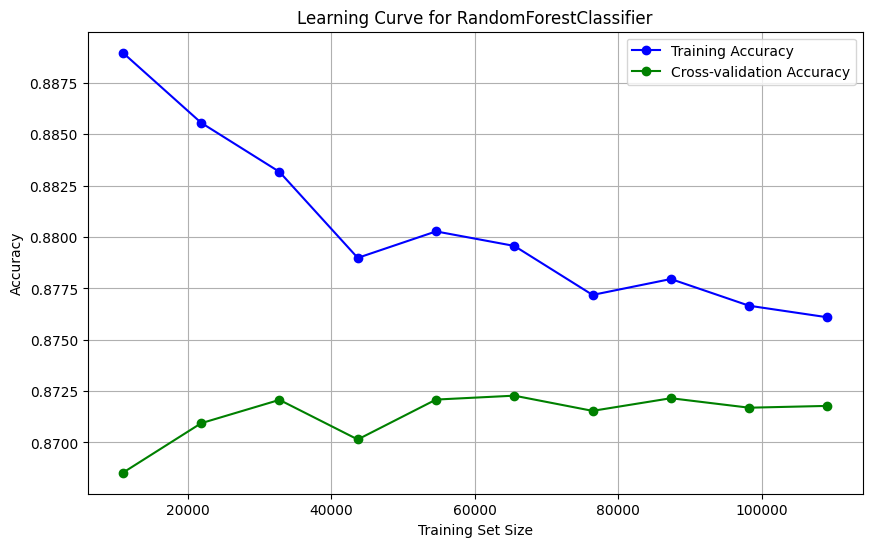

In [129]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    estimator=clf,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Mean and std for plotting
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation Accuracy')
plt.title('Learning Curve for RandomForestClassifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()
